In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [447]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

import torch
from torch import Tensor
from torch import nn

plt.rcParams["image.cmap"] = "copper"  # For immersive Mars vibe

In [400]:
x_train = pd.read_csv("./train_damaged.csv")
x_train.index = x_train.pop("Id")
x_train = x_train.to_numpy().reshape(-1, 50, 50)

y_train = pd.read_csv("./train_undamaged.csv")
y_train.index = y_train.pop("Id")
y_train = y_train.to_numpy().reshape(-1, 100, 100)

x_val = pd.read_csv("./train_damaged.csv")
x_val.index = x_val.pop("Id")
x_val = x_val.to_numpy().reshape(-1, 50, 50)

In [402]:
x_train, x_test = x_train[:160],x_train[160:]
y_train, y_test = y_train[:160],y_train[160:]

In [462]:
def downsize(a):
    assert a.shape == (100,100)

    xaxis = np.arange(0,100,2).reshape(-1,1)
    yaxis = np.arange(0,100,2)
    return (a[xaxis,yaxis] + 
           a[xaxis+1,yaxis]+
           a[xaxis,yaxis+1]+
           a[xaxis+1,yaxis+1])/4

In [459]:
Loss = torch.nn.MSELoss()
class Model:

    def __init__(self):
        input_dim, hidden_dim, output_dim = 2500,5000,2500
        self.l1 = nn.Linear(input_dim, hidden_dim )
        self.l2 = nn.Linear(hidden_dim,output_dim)

        self.parameters = [*self.l1.parameters(), *self.l2.parameters()]
    
    def __call__(self,x):
        x = Tensor(x).reshape(-1,2500)
        x = self.l1(x)
        x = nn.functional.relu(x)
        x = self.l2(x)
        return x

model = Model()
opt = torch.optim.Adam(model.parameters,lr=0.0001)

Loss = nn.MSELoss()
def loss_fn (p,y):

    for i in range(len (y)):
        y[i] = downsize(y[i])
    y = Tensor(downsize(y)).reshape(-1)
    return Loss(y,p)
    
def train_step(x,y):

    pred = model(x)
    loss = loss_fn(pred,y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    global hist
    hist.append(loss.detach().numpy())


loss_hist = []

def test ():
    loss = 0
    for x,y in zip(x_test,y_test):
        loss += loss_fn(model(x),y)
    return loss / x_test.shape[0]

def epoch (e=0):
    xlen = x_train.shape[0]
    batch_size = 4
    for i in range(0,xlen,batch_size):

        x,y = x_train[i:i+batch_size],y_train[i:i+batch_size]
        print (f'\r epoch {e} batch {i}/{x_train.shape[0]} ',end="")
        
        train_step(x,y)

def train(epochs = 10):
    global hist
    for e in range(epochs):

        epoch(e)

        train_loss= sum(hist)/len(hist)
        test_loss = test().detach().numpy()

        print (f"avg train loss: {train_loss:.5} test loss: {test_loss:.5}")

        loss_hist.append((train_loss,test_loss))


train()


 epoch 0 batch 0/160 

AssertionError: 

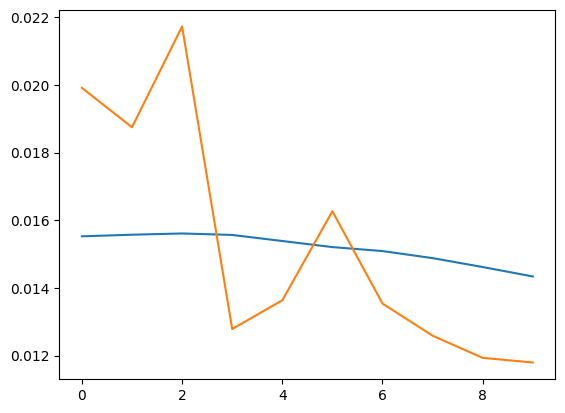

In [454]:
plt.plot(np.array(loss_hist))

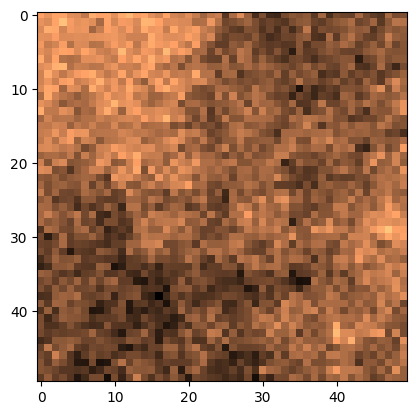

In [439]:
imshow(model(x_train[0]).detach().numpy().reshape((50,50)))

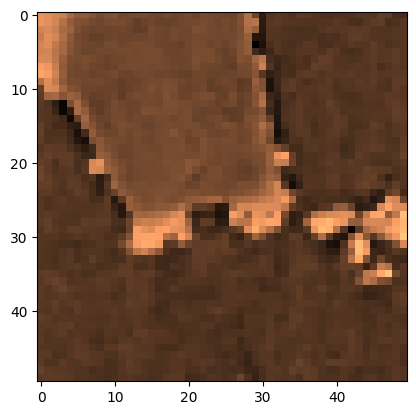

In [440]:
imshow(downsize(y_train[0]))